# HW3: Task
Predict the region and area (or areaname) of olive oils based on their fatty acid contents.source 

The task's source is http://www.ggobi.org/book/

Fit and evaluate the classification predictions of LDA, LogisticRegression, SVM, k-NN, and 
Random Forests for both the region and area.

### 20 pts for each classifier

You may use the Classification Jupyter Notebook Dr. Kalpakis prepared for the class.

## Dataset description and data

In [66]:
#Malik Jackson 491 Data Science
from IPython.display import IFrame
from sklearn.svm import SVC
from sklearn.svm import LinearSVC 
import pandas
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn import  model_selection,metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import re
import inspect

IFrame("OliveOil2.pdf", height=100, width=100, embed=True)

#Hey there! So in this notebook, we'll be  applying some basic classification principles to action, 
#discussing the process of classifciation at a high level and looking at some results.

In [3]:
#This project makes use of Dr Kalpakis' Classification notebook, so we'll use a lot of his functions he's defined.
def isOneOfMany(y):
    if y.ndim > 1 and y.shape[1] > 1:
        return True
    return False

def is_method(obj, name):
    val = False
    if hasattr(obj, name) and inspect.ismethod(getattr(obj, name)):
        val = True
    #print(obj, name, val)
    return val

def modelPredict(X_this, y_this, model):
    # y_hat, y_score, y_prob = modelPredict(X_this, y_this, model)
    y_hat = classifier.predict(X_this)
    y_score = np.zeros_like(y_this) #.fill(np.nan) 
    y_score = y_hat
    y_prob = np.zeros_like(y_this) #.fill(np.nan)
    y_prob = y_hat
    if is_method(model, 'decision_function'): 
        y_score = classifier.decision_function(X_this)
    if is_method(model, 'predict_proba'): 
        y_prob = classifier.predict_proba(X_this)
    return (y_hat, y_score, y_prob)

def classifierConfusionMatrix(y, y_hat, n_classes=2, class_labels=None, title=None, ax=None, cmap=plt.cm.Blues):
    # Construct and plot a multi-class confusion matrix; 
    # C[i,j] is the fraction of true class i predicted as class j
    
    if class_labels is None:
        class_labels = ['Class ' + str(i) for i in range(n_classes)]
        
    #Compute confusion matrix and then normalize it (row-wise)
    if isOneOfMany(y):
        cm = metrics.confusion_matrix(y.argmax(1), y_hat.argmax(1))
    else:
        cm = metrics.confusion_matrix(y, y_hat)
        
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = pd.DataFrame(cm, columns=class_labels, index=class_labels)
    #print("Normalized Confusion matrix\n", cm)
    
    if class_labels is None:
        class_labels = ['Class ' + str(i) for i in range(n_classes)]
    
    if ax is None:
        fig = plt.figure()
        ax = plt.gca()
    
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=True, yticklabels=True, cmap=cmap, ax=ax)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix [%s]' % title)
    
def plot1classROC(y, y_score, title='', ax=None):
    # assumes a binary classification problem, eg y is a single column array of 0 and 1's
    fpr, tpr, _ = metrics.roc_curve(y, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 1
    if ax is None:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()
        
    ax.plot(fpr, tpr, color='darkgreen', lw=1, label='ROC (auc = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    ax.set_title('ROC [%s]' % title)
    
def plotMultiClassROC(y, y_score, n_classes, title='', lw=1, ax=None, class_labels=None):
    # Compute macro-average ROC curve and ROC area for a multi-class classification where
    # y (and y_hat and y_score) is OneHot encoded eg it has n_classes columns 
    
    from scipy import interp
    from itertools import cycle
    
    if class_labels is None:
        class_labels = ['Class ' + str(i) for i in range(n_classes)]
        
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()   
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    #y = pandas.get_dummies(y)
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

    if ax is None:
        fig = plt.figure(figsize=(10, 8));
        ax = plt.gca()
        
    if class_labels is None:
        class_labels = ['class %d' % i for i in range(n_classes)]
        
    # Plot all ROC curves
    ax.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

    ax.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        label = class_labels[i]
        ax.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (auc = {1:0.2f})'
             ''.format(label, roc_auc[i]))

    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC [%s]' % title)
    ax.legend(loc="lower right")

def classifierPerformance(y, y_hat, y_score, n_classes=2, class_labels=None, title=None, ax=None):
    
    if class_labels is None:
        class_labels = ['Class ' + str(i) for i in range(n_classes)]
        
    print('Classification Report [%s]' % title)
    print(metrics.classification_report(y, y_hat, target_names=class_labels))

    print('Accuracy score= %.4f' % metrics.accuracy_score(y, y_hat))
    if isOneOfMany(y):
        ck = metrics.cohen_kappa_score(y.argmax(1), y_hat.argmax(1))
    else:
        ck = metrics.cohen_kappa_score(y, y_hat)
    
    print("Cohen's Kappa score= %.4f" % ck)
    
    classifierConfusionMatrix(y, y_hat, n_classes=n_classes, class_labels=class_labels, title=title)
    if n_classes == 2:
        plot1classROC(y, y_score, title=title, ax=ax)
    
    if n_classes > 2:
        plotMultiClassROC(y, y_score, n_classes, title=title, class_labels=class_labels, ax=ax)

In [4]:
%matplotlib inline
import pandas as pd

In [12]:
# We'll load the data set and then make a duplicate, removing the values we want to predict. 

#The set of all regions or the set of all areas will comprise our classes and the X, duplicate that we defined will 
#comprise our classes. The X data frame will comprise our predictors

# The dataset
df=pd.read_csv("olive.csv")
df.rename(columns={df.columns[0]:'areaname'}, inplace=True)
df.areaname=df.areaname.map(lambda x: x.split('.')[-1])
df.sample(50).head(10)

X = df.copy()

del X["areaname"]
del X["region"]
del X["area"]

df.head()

areaname  region  area  palmitic  palmitoleic  stearic  oleic  \
0  North-Apulia       1     1      1075           75      226   7823   
1  North-Apulia       1     1      1088           73      224   7709   
2  North-Apulia       1     1       911           54      246   8113   
3  North-Apulia       1     1       966           57      240   7952   
4  North-Apulia       1     1      1051           67      259   7771   

   linoleic  linolenic  arachidic  eicosenoic  
0       672         36         60          29  
1       781         31         61          29  
2       549         31         63          29  
3       619         50         78          35  
4       672         50         80          46

In [13]:

predictors = []
for a in df:
    predictors.append(a)
    
    
y1 = df.areaname
y2 = df.region

n_classes1 = len(df['areaname'].unique())
n_classes2 = len(df['region'].unique())

class1_vals = df['areaname'].unique()
class2_vals = df['region'].unique()

class1_labels = [ 'Class 1 Label: %d' % i for i in range(n_classes1)]
class2_labels = [ 'Class 2 Label: %d' % i for i in range(n_classes2)]
print class1_vals
print class2_vals

['North-Apulia' 'Calabria' 'South-Apulia' 'Sicily' 'Inland-Sardinia'
 'Coast-Sardinia' 'Umbria' 'East-Liguria' 'West-Liguria']
[1 2 3]


## 1. LDA

Classification Report [Testing]
                precision    recall  f1-score   support

Class2Label: 0       1.00      0.99      1.00       157
Class2Label: 1       0.98      1.00      0.99        55
Class2Label: 2       0.95      0.97      0.96        74

   avg / total       0.98      0.99      0.99       286

Accuracy score= 0.9790
Cohen's Kappa score= 0.9824
clear


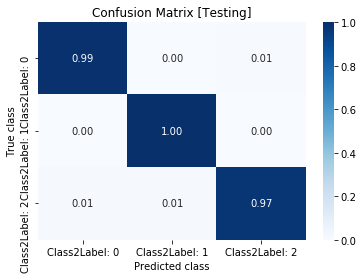

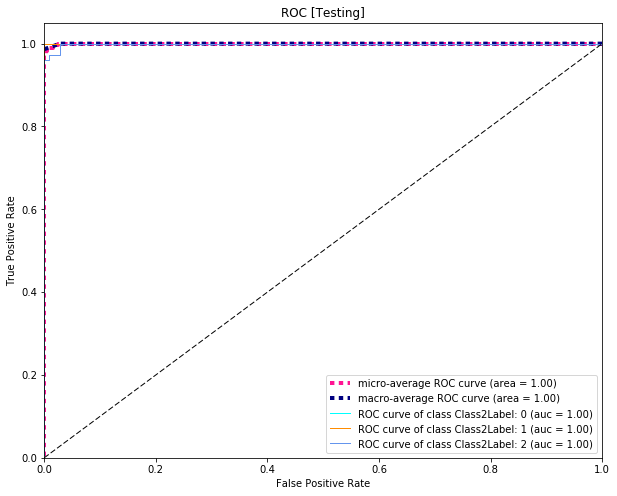

In [49]:
#Note, each classifier first classifies the area, then the region, so you'll see and almost duplicate implementation
#per classifier

#Our general form for each classifier is to load the model,  whic we can import form scikit
model = LinearDiscriminantAnalysis()
classifier = OneVsRestClassifier(model)


#We'll also want to test and train our model on our data set 
# shuffle and split training and test sets
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X.as_matrix(),  pandas.get_dummies(y2).as_matrix(), test_size=.5, random_state=0)

experiment2, X_this2, y_this2 = 'Training', X_train2, y_train2
experiment2, X_this2, y_this2 = 'Testing', X_test2, y_test2

#We'll want to make the model of classifier fit the curve of the data we would have if we could multidimensionally
#graph it. By this iI mean, between testing and fitting, we want to fit the model so that the descions it makes
#to determine the area or region match the actual fatty acid comntents of the area and region of the olive oil
#it classifies
# fit the classifier to the training set
classifier2 = classifier.fit(X_train2, y_train2).decision_function(X_test2)

#We'll then test our classifier by predicitng the classes of our predictor set, the df with the area and region removed.
#Since we predict on the same set we test and train on, we should see nearly flawless results. 
y_hat2, y_score2, y_prob2 = modelPredict(X_test2, y_test2, model)

#Then we can check out our performance stats and confusion matrix to see false pasitives,true positives,
#False negative and true negatives. Generally we see good results! We see really good accuracy and precision
#Meaning our model is not only good at being accurate, but also good at being consistently accurate. Our roc curve
#shows us how the  rate fasle positive and True positive identification progresses over the span of our data.
classifierPerformance(y_test2, y_hat2, y_score2, n_classes2, class_labels=class2_labels, title='Testing')

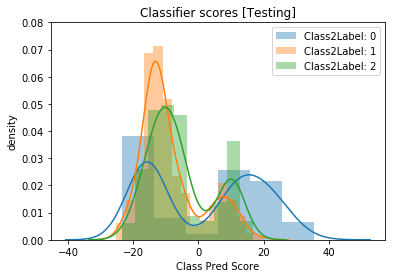

In [38]:
#An additional grah here give us another visualization of our classification scores for prediction.
for i in range(n_classes2): 
    ax = sns.distplot(y_score2[:,i], hist=True, kde=True, rug=False, norm_hist=True, label=class2_labels[i])    
ax.set_title('Classifier scores')
ax.set_xlabel('Class Pred Score')
ax.set_ylabel('density')
ax.set_ylim([0,0.08])
ax.legend() 

Classification Report [Testing]
                precision    recall  f1-score   support

Class1Label: 0       0.70      0.62      0.65        26
Class1Label: 1       0.81      0.94      0.87        18
Class1Label: 2       1.00      0.75      0.86        24
Class1Label: 3       0.57      0.65      0.61        37
Class1Label: 4       0.80      0.80      0.80        15
Class1Label: 5       0.52      0.73      0.61        15
Class1Label: 6       0.95      0.98      0.97       101
Class1Label: 7       0.86      1.00      0.92        24
Class1Label: 8       0.87      1.00      0.93        26

   avg / total       0.83      0.86      0.84       286

Accuracy score= 0.7203
Cohen's Kappa score= 0.8161
clear


"\nmodel = LinearDiscriminantAnalysis()\nclassifier = OneVsRestClassifier(model)\n\n# shuffle and split training and test sets\nX_train, X_test, y_train, y_test = model_selection.train_test_split(X.as_matrix(), y1, test_size=.5, random_state=0)\n\n# fit the classifier to the training set\nclassifier1 = classifier.fit(X_train, y_train)\n\ny_hat, y_score, y_prob = modelPredict(X_test, y_test, model)\n\nclassifierPerformance(y_test, y_hat, y_score, n_classes1, class_labels=class1_labels, title='Testing')\n"

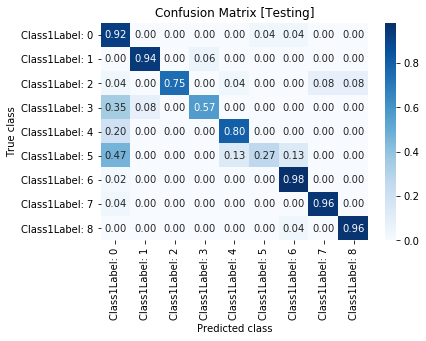

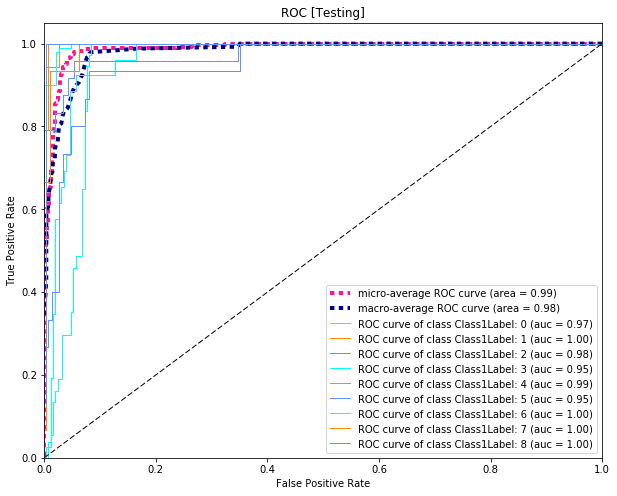

In [47]:
#The rest of our classifiers will follow this exact setup as the first.
# 2 Classification by region for lda
model = LinearDiscriminantAnalysis()
classifier = OneVsRestClassifier(model)

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X.as_matrix(),  pandas.get_dummies(y1).as_matrix(), test_size=.5, random_state=0)

# fit the classifier to the training set

classifier1 = classifier.fit(X_train, y_train).decision_function(X_test)

y_hat, y_score, y_prob = modelPredict(X_test, y_test, model)

classifierPerformance(y_test, y_hat, y_score, n_classes1, class_labels=class1_labels, title='Testing')

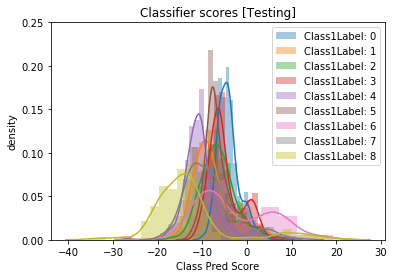

In [44]:
for i in range(n_classes1): 
    ax = sns.distplot(y_score[:,i], hist=True, kde=True, rug=False, norm_hist=True, label=class1_labels[i])    
ax.set_title('Classifier scores )
ax.set_xlabel('Class Pred Score')
ax.set_ylabel('density')
ax.set_ylim([0,0.25])
ax.legend() 

## 2. Logistic Regression

C:\Anaconda2\lib\site-packages\sklearn\linear_model\sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Classification Report [Testing]
                precision    recall  f1-score   support

Class2Label: 0       0.99      0.97      0.98       157
Class2Label: 1       0.92      0.87      0.90        55
Class2Label: 2       0.94      0.92      0.93        74

   avg / total       0.97      0.94      0.95       286

Accuracy score= 0.9196
Cohen's Kappa score= 0.8982
clear


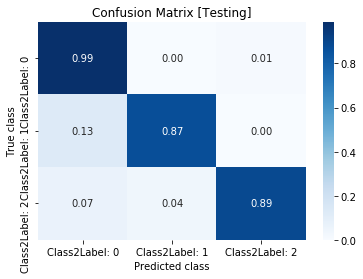

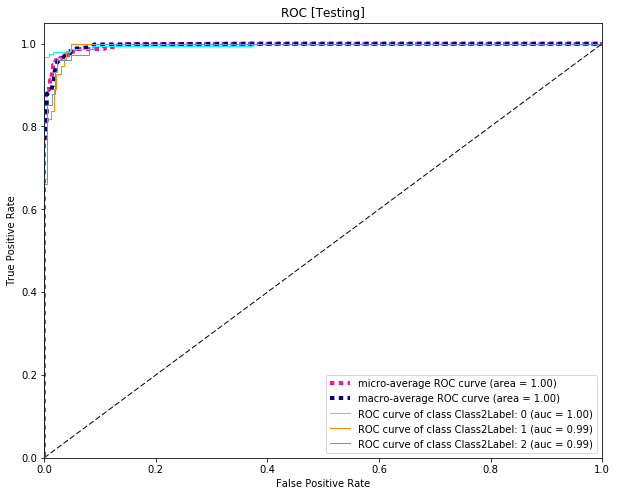

In [57]:
model = LogisticRegression(C=1e5, solver='sag', multi_class='multinomial', max_iter=1000, 
                                        class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1,
                                        penalty='l2', tol=0.0001, verbose=0, warm_start=False)
classifier = OneVsRestClassifier(model)

# shuffle and split training and test sets
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X.as_matrix(),  pandas.get_dummies(y2).as_matrix(), test_size=.5, random_state=0)

experiment2, X_this2, y_this2 = 'Training', X_train2, y_train2
experiment2, X_this2, y_this2 = 'Testing', X_test2, y_test2

# fit the classifier to the training set

classifier2 = classifier.fit(X_train2, y_train2).decision_function(X_test2)

y_hat2, y_score2, y_prob2 = modelPredict(X_test2, y_test2, model)


classifierPerformance(y_test2, y_hat2, y_score2, n_classes2, class_labels=class2_labels, title='Testing')

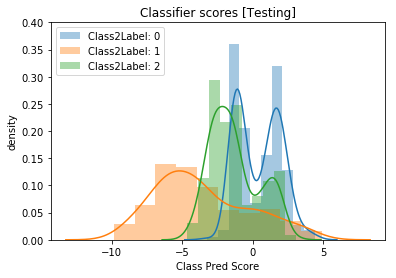

In [60]:
for i in range(n_classes2): 
    ax = sns.distplot(y_score2[:,i], hist=True, kde=True, rug=False, norm_hist=True, label=class2_labels[i])    
ax.set_title('Classifier scores')
ax.set_xlabel('Class Pred Score')
ax.set_ylabel('density')
ax.set_ylim([0,0.4])
ax.legend() 

Classification Report [Testing]
                precision    recall  f1-score   support

Class1Label: 0       0.70      0.62      0.65        26
Class1Label: 1       0.81      0.94      0.87        18
Class1Label: 2       1.00      0.75      0.86        24
Class1Label: 3       0.57      0.65      0.61        37
Class1Label: 4       0.80      0.80      0.80        15
Class1Label: 5       0.52      0.73      0.61        15
Class1Label: 6       0.95      0.98      0.97       101
Class1Label: 7       0.86      1.00      0.92        24
Class1Label: 8       0.87      1.00      0.93        26

   avg / total       0.83      0.86      0.84       286

Accuracy score= 0.7203
Cohen's Kappa score= 0.8161
clear


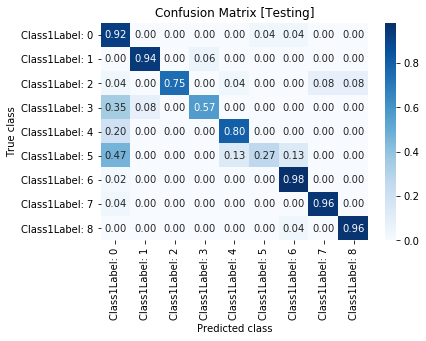

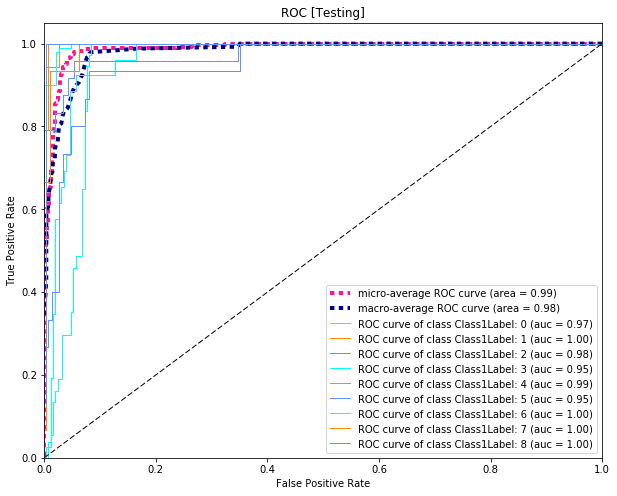

In [68]:
model = LinearDiscriminantAnalysis()
classifier = OneVsRestClassifier(model)

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X.as_matrix(),  pandas.get_dummies(y1).as_matrix(), test_size=.5, random_state=0)

# fit the classifier to the training set

classifier1 = classifier.fit(X_train, y_train).decision_function(X_test)

y_hat, y_score, y_prob = modelPredict(X_test, y_test, model)

classifierPerformance(y_test, y_hat, y_score, n_classes1, class_labels=class1_labels, title='Testing')

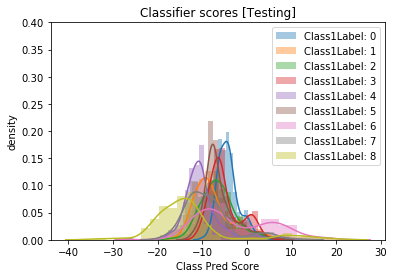

In [69]:
for i in range(n_classes1): 
    ax = sns.distplot(y_score[:,i], hist=True, kde=True, rug=False, norm_hist=True, label=class1_labels[i])    
ax.set_title('Classifier scores')
ax.set_xlabel('Class Pred Score')
ax.set_ylabel('density')
ax.set_ylim([0,0.4])
ax.legend() 

## 3. SVM

Classification Report [Testing]
                precision    recall  f1-score   support

Class2Label: 0       1.00      0.96      0.98       157
Class2Label: 1       0.96      0.84      0.89        55
Class2Label: 2       0.52      1.00      0.69        74

   avg / total       0.87      0.94      0.89       286

Accuracy score= 0.7552
Cohen's Kappa score= 0.9066
clear


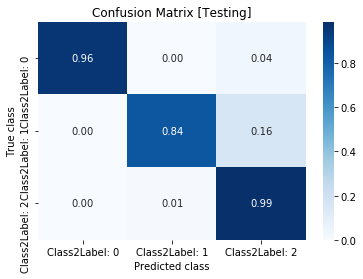

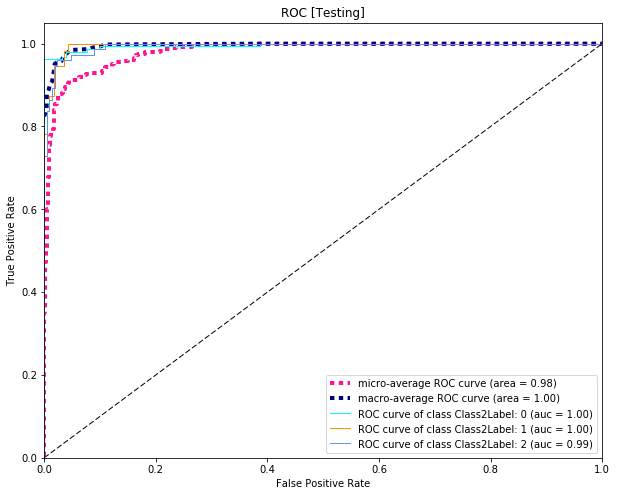

In [67]:
model = LinearSVC()
classifier = OneVsRestClassifier(model)

# shuffle and split training and test sets
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X.as_matrix(),  pandas.get_dummies(y2).as_matrix(), test_size=.5, random_state=0)

experiment2, X_this2, y_this2 = 'Training', X_train2, y_train2
experiment2, X_this2, y_this2 = 'Testing', X_test2, y_test2

# fit the classifier to the training set

classifier2 = classifier.fit(X_train2, y_train2).decision_function(X_test2)

y_hat2, y_score2, y_prob2 = modelPredict(X_test2, y_test2, model)


classifierPerformance(y_test2, y_hat2, y_score2, n_classes2, class_labels=class2_labels, title='Testing')

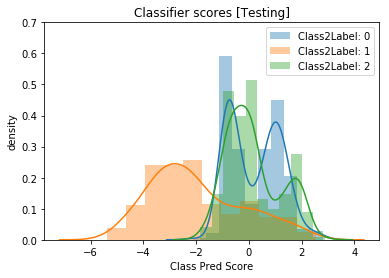

In [72]:
for i in range(n_classes2): 
    ax = sns.distplot(y_score2[:,i], hist=True, kde=True, rug=False, norm_hist=True, label=class2_labels[i])    
ax.set_title('Classifier scores')
ax.set_xlabel('Class Pred Score')
ax.set_ylabel('density')
ax.set_ylim([0,0.7])
ax.legend() 

Classification Report [Testing]
                precision    recall  f1-score   support

Class2Label: 0       1.00      0.97      0.98       157
Class2Label: 1       0.92      0.87      0.90        55
Class2Label: 2       0.94      0.92      0.93        74

   avg / total       0.97      0.94      0.95       286

Accuracy score= 0.9196
Cohen's Kappa score= 0.8982
clear


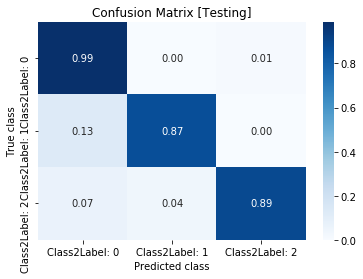

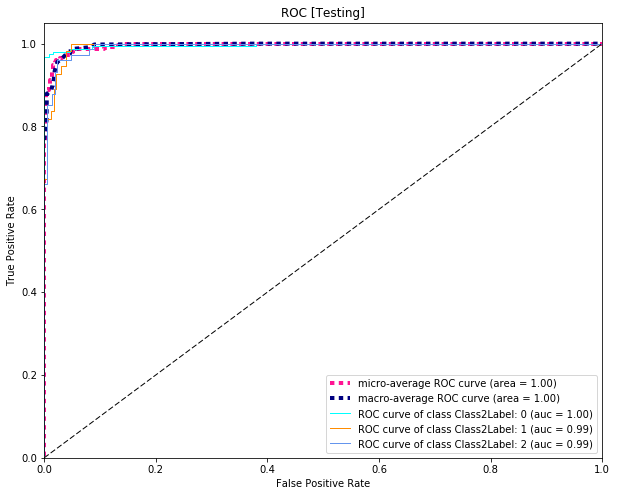

In [73]:
model = LogisticRegression(C=1e5, solver='sag', multi_class='multinomial', max_iter=1000, 
                                        class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1,
                                        penalty='l2', tol=0.0001, verbose=0, warm_start=False)
classifier = OneVsRestClassifier(model)

# shuffle and split training and test sets
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X.as_matrix(),  pandas.get_dummies(y2).as_matrix(), test_size=.5, random_state=0)

experiment2, X_this2, y_this2 = 'Training', X_train2, y_train2
experiment2, X_this2, y_this2 = 'Testing', X_test2, y_test2

# fit the classifier to the training set

classifier2 = classifier.fit(X_train2, y_train2).decision_function(X_test2)

y_hat2, y_score2, y_prob2 = modelPredict(X_test2, y_test2, model)


classifierPerformance(y_test2, y_hat2, y_score2, n_classes2, class_labels=class2_labels, title='Testing')

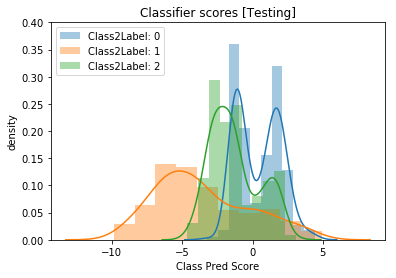

In [74]:
for i in range(n_classes2): 
    ax = sns.distplot(y_score2[:,i], hist=True, kde=True, rug=False, norm_hist=True, label=class2_labels[i])    
ax.set_title('Classifier scores')
ax.set_xlabel('Class Pred Score')
ax.set_ylabel('density')
ax.set_ylim([0,0.4])
ax.legend() 

## 4. k-NN

Classification Report [Testing]
                precision    recall  f1-score   support

Class2Label: 0       0.97      0.92      0.94       157
Class2Label: 1       0.98      1.00      0.99        55
Class2Label: 2       0.85      0.93      0.89        74

   avg / total       0.94      0.94      0.94       286

Accuracy score= 0.9371
Cohen's Kappa score= 0.8956
clear


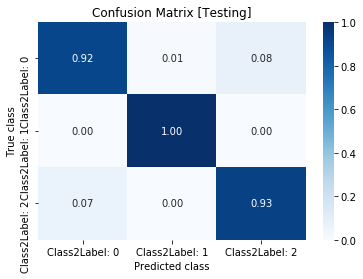

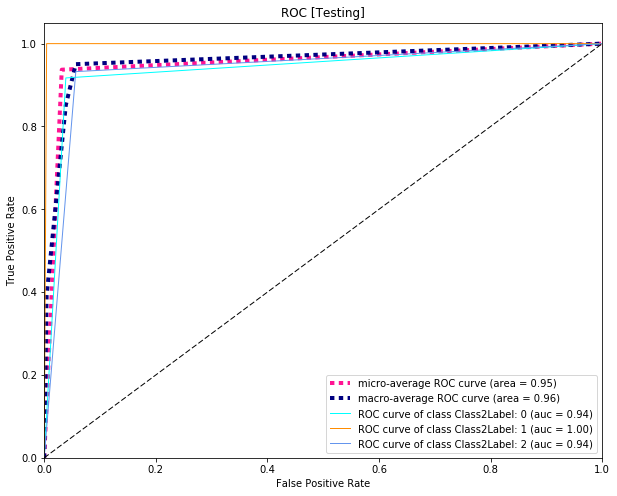

In [76]:
model = KNeighborsClassifier()
classifier = OneVsRestClassifier(model)

# shuffle and split training and test sets
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X.as_matrix(),  pandas.get_dummies(y2).as_matrix(), test_size=.5, random_state=0)

experiment2, X_this2, y_this2 = 'Training', X_train2, y_train2
experiment2, X_this2, y_this2 = 'Testing', X_test2, y_test2

# fit the classifier to the training set

classifier2 = classifier.fit(X_train2, y_train2).predict_proba(X_test2)

y_hat2, y_score2, y_prob2 = modelPredict(X_test2, y_test2, model)


classifierPerformance(y_test2, y_hat2, y_score2, n_classes2, class_labels=class2_labels, title='Testing')

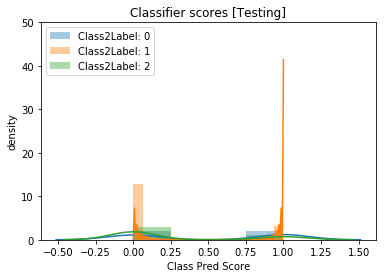

In [84]:
for i in range(n_classes2): 
    ax = sns.distplot(y_score2[:,i], hist=True, kde=True, rug=False, norm_hist=True, label=class2_labels[i])    
ax.set_title('Classifier scores')
ax.set_xlabel('Class Pred Score')
ax.set_ylabel('density')
ax.set_ylim([0,50])
ax.legend() 

Classification Report [Testing]
                precision    recall  f1-score   support

Class1Label: 0       0.70      0.62      0.65        26
Class1Label: 1       0.81      0.94      0.87        18
Class1Label: 2       1.00      0.75      0.86        24
Class1Label: 3       0.57      0.65      0.61        37
Class1Label: 4       0.80      0.80      0.80        15
Class1Label: 5       0.52      0.73      0.61        15
Class1Label: 6       0.95      0.98      0.97       101
Class1Label: 7       0.86      1.00      0.92        24
Class1Label: 8       0.87      1.00      0.93        26

   avg / total       0.83      0.86      0.84       286

Accuracy score= 0.7203
Cohen's Kappa score= 0.8161
clear


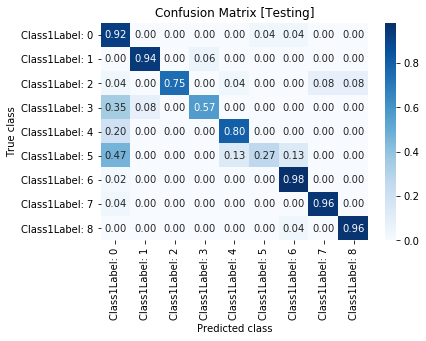

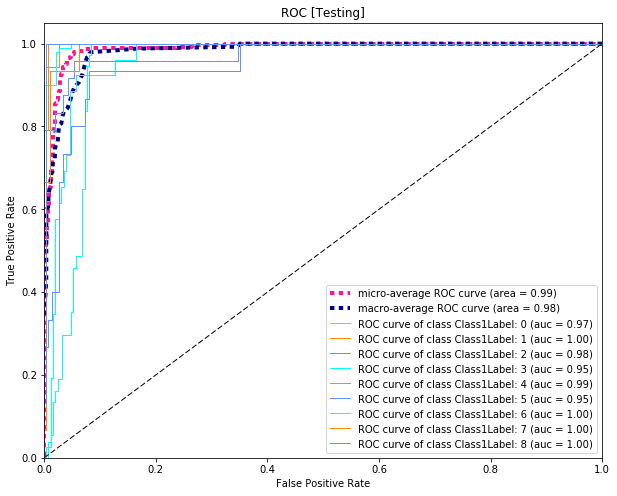

In [85]:
model = LinearDiscriminantAnalysis()
classifier = OneVsRestClassifier(model)

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X.as_matrix(),  pandas.get_dummies(y1).as_matrix(), test_size=.5, random_state=0)

# fit the classifier to the training set

classifier1 = classifier.fit(X_train, y_train).predict_proba(X_test)

y_hat, y_score, y_prob = modelPredict(X_test, y_test, model)

classifierPerformance(y_test, y_hat, y_score, n_classes1, class_labels=class1_labels, title='Testing')

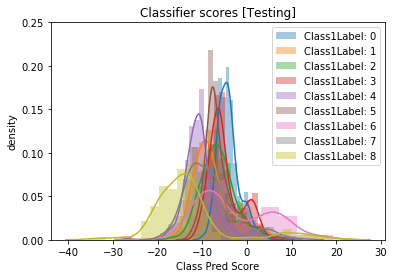

In [86]:
for i in range(n_classes1): 
    ax = sns.distplot(y_score[:,i], hist=True, kde=True, rug=False, norm_hist=True, label=class1_labels[i])    
ax.set_title('Classifier scores')
ax.set_xlabel('Class Pred Score')
ax.set_ylabel('density')
ax.set_ylim([0,0.25])
ax.legend() 

## 5. Random Forest

Classification Report [Testing]
                precision    recall  f1-score   support

Class2Label: 0       1.00      1.00      1.00       157
Class2Label: 1       1.00      1.00      1.00        55
Class2Label: 2       1.00      0.93      0.97        74

   avg / total       1.00      0.98      0.99       286

Accuracy score= 0.9825
Cohen's Kappa score= 0.9704
clear


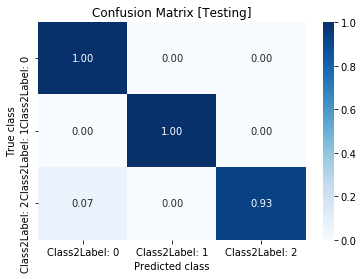

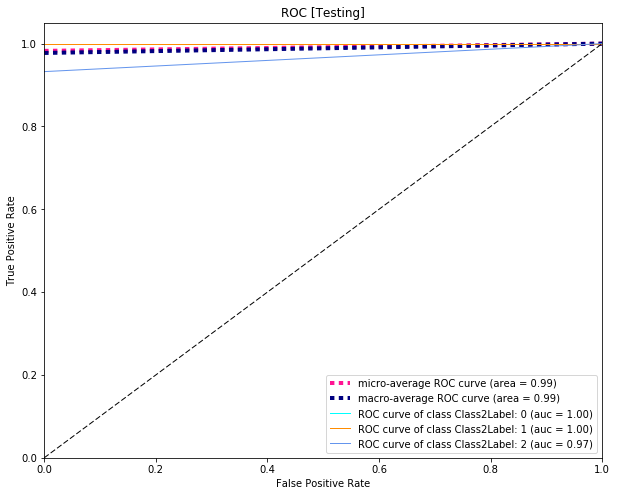

In [89]:
model = RandomForestClassifier(max_depth=2)
classifier = OneVsRestClassifier(model)

# shuffle and split training and test sets
X_train2, X_test2, y_train2, y_test2 = model_selection.train_test_split(X.as_matrix(),  pandas.get_dummies(y2).as_matrix(), test_size=.5, random_state=0)

experiment2, X_this2, y_this2 = 'Training', X_train2, y_train2
experiment2, X_this2, y_this2 = 'Testing', X_test2, y_test2

# fit the classifier to the training set

classifier2 = classifier.fit(X_train2, y_train2).predict_proba(X_test2)

y_hat2, y_score2, y_prob2 = modelPredict(X_test2, y_test2, model)
classifierPerformance(y_test2, y_hat2, y_score2, n_classes2, class_labels=class2_labels, title='Testing')

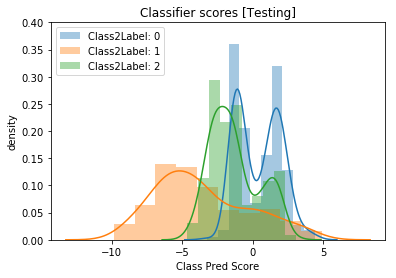

In [62]:
for i in range(n_classes2): 
    ax = sns.distplot(y_score2[:,i], hist=True, kde=True, rug=False, norm_hist=True, label=class2_labels[i])    
ax.set_title('Classifier scores')
ax.set_xlabel('Class Pred Score')
ax.set_ylabel('density')
ax.set_ylim([0,0.4])
ax.legend() 

Classification Report [Testing]
                precision    recall  f1-score   support

Class1Label: 0       0.70      0.62      0.65        26
Class1Label: 1       0.81      0.94      0.87        18
Class1Label: 2       1.00      0.75      0.86        24
Class1Label: 3       0.57      0.65      0.61        37
Class1Label: 4       0.80      0.80      0.80        15
Class1Label: 5       0.52      0.73      0.61        15
Class1Label: 6       0.95      0.98      0.97       101
Class1Label: 7       0.86      1.00      0.92        24
Class1Label: 8       0.87      1.00      0.93        26

   avg / total       0.83      0.86      0.84       286

Accuracy score= 0.7203
Cohen's Kappa score= 0.8161
clear


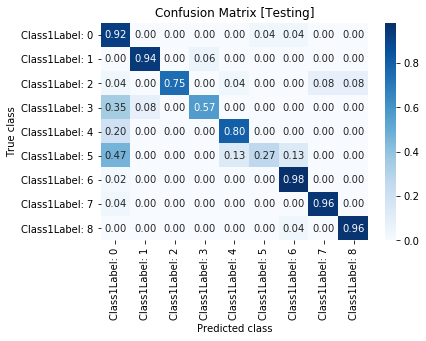

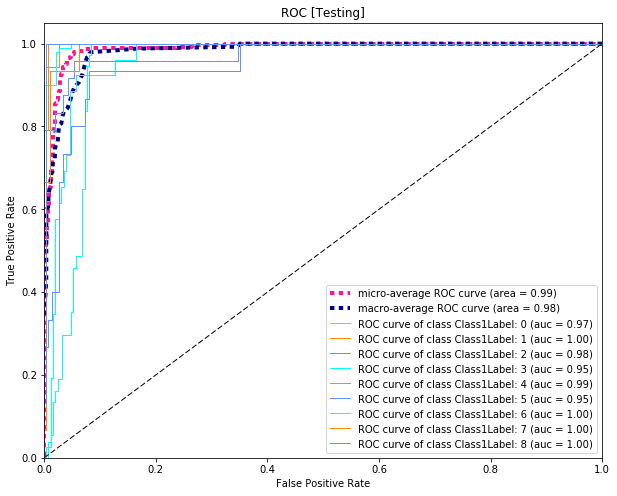

In [90]:
model = LinearDiscriminantAnalysis()
classifier = OneVsRestClassifier(model)

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X.as_matrix(),  pandas.get_dummies(y1).as_matrix(), test_size=.5, random_state=0)

# fit the classifier to the training set

classifier1 = classifier.fit(X_train, y_train).decision_function(X_test)

y_hat, y_score, y_prob = modelPredict(X_test, y_test, model)

classifierPerformance(y_test, y_hat, y_score, n_classes1, class_labels=class1_labels, title='Testing')

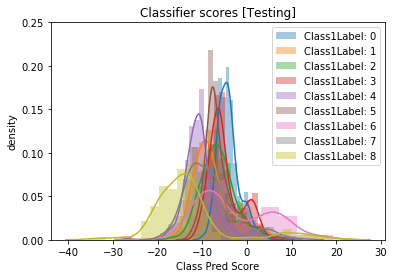

In [91]:
for i in range(n_classes1): 
    ax = sns.distplot(y_score[:,i], hist=True, kde=True, rug=False, norm_hist=True, label=class1_labels[i])    
ax.set_title('Classifier scores')
ax.set_xlabel('Class Pred Score')
ax.set_ylabel('density')
ax.set_ylim([0,0.25])
ax.legend() 